<a href="https://colab.research.google.com/github/AnberAziz/BS-DS-Project/blob/main/AnberW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [5]:
print("--- Step 1: Automatic Data Loading ---")

# 1. Load Data directly from a GitHub URL (Reliable fallback)
url = "https://raw.githubusercontent.com/basilatawneh/Students-Academic-Performance-Dataset-xAPI-Edu-Data-/master/xAPI-Edu-Data.csv"

try:
    df = pd.read_csv(url)
    print("✅ Success: Data loaded from GitHub URL.")
except Exception as e:
    print(f"❌ Error: Could not download data. Error: {e}")
    # Stop execution if data isn't found
    raise SystemExit("Stop: Check internet connection or URL.")

--- Step 1: Automatic Data Loading ---
✅ Success: Data loaded from GitHub URL.


In [6]:
# 2. Basic Cleaning (Matching previous weeks)
df.rename(columns={'NationalITy': 'Nationality', 'raisedhands': 'raised_hands', 'VisITedResources': 'visited_resources'}, inplace=True)

In [7]:
# 3. Encoding Target Variable (Class: L, M, H -> 0, 1, 2)
class_map = {'L': 0, 'M': 1, 'H': 2}
df['class_label_encoded'] = df['Class'].map(class_map)

In [8]:
# 4. Feature Selection & Encoding
features = ['raised_hands', 'visited_resources', 'AnnouncementsView', 'Discussion',
            'StudentAbsenceDays', 'ParentAnsweringSurvey', 'Relation', 'gender']

X = df[features]
y = df['class_label_encoded']

# One-Hot Encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

In [9]:
# 5. Scaling (CRITICAL for Neural Networks)
# We MUST scale data for ANN (Random Forest didn't need this, but ANN does)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data Prepared: Training on 384 samples, Testing on 96 samples.

--- Step 2: Building the ANN Model ---
Model Compiled. Starting Training (50 Epochs)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Complete.

--- Step 3: Evaluation ---
ANN Test Accuracy: 77.08%


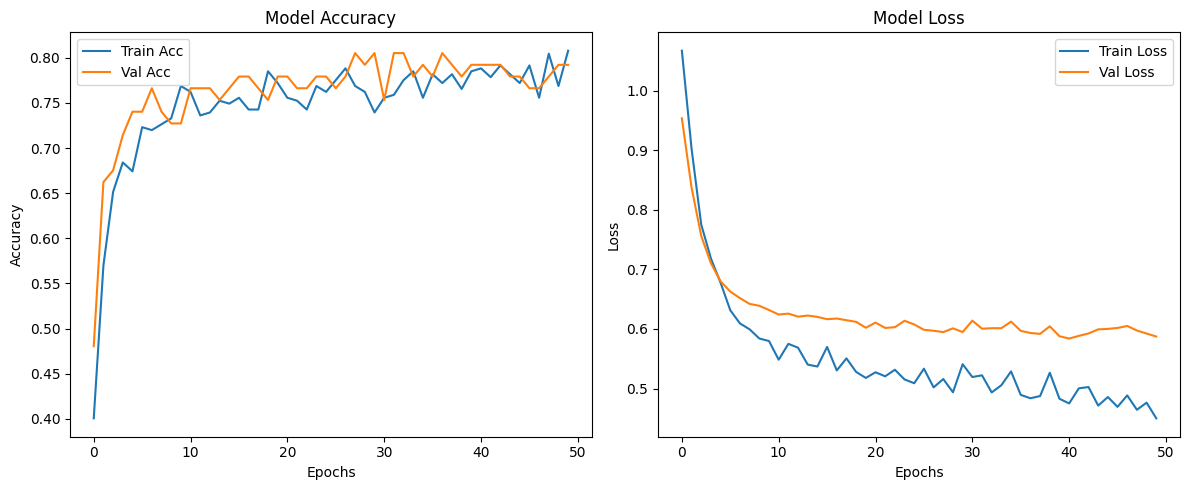

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
              precision    recall  f1-score   support

         Low       0.85      0.88      0.87        26
      Medium       0.72      0.79      0.75        42
        High       0.78      0.64      0.71        28

    accuracy                           0.77        96
   macro avg       0.78      0.77      0.77        96
weighted avg       0.77      0.77      0.77        96



In [10]:
# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Prepared: Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]} samples.")

print("\n--- Step 2: Building the ANN Model ---")

# Define the Model Architecture
# Input Layer -> Hidden Layer 1 (64 neurons) -> Hidden Layer 2 (32 neurons) -> Output (3 classes)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Input Layer
    Dropout(0.3), # Regularization (drops 30% of neurons randomly to prevent overfitting)
    Dense(32, activation='relu'),                                  # Hidden Layer
    Dropout(0.2),
    Dense(3, activation='softmax')                                 # Output Layer (3 Classes: L, M, H)
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Used for integer targets (0, 1, 2)
              metrics=['accuracy'])

print("Model Compiled. Starting Training (50 Epochs)...")

# Train
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=0) # verbose=0 hides the epoch-by-epoch log

print("Training Complete.")

print("\n--- Step 3: Evaluation ---")

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"ANN Test Accuracy: {accuracy*100:.2f}%")

# Plot Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))